## **Unconditional Denoising Diffusion Probabilistic Model**

This notebook trains an unconditional denoising diffusion probabilistic model (DDPM) on the CIFAR-10 dataset. 

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 

In [5]:
# Load dataset 
# We apply the lambda rescaling below so that each pixel from the [0, 1] range rescales to the range [1, -1]. 
# During the forward process, DDPMs add Gaussian noise ~ N (0, 1) to the images. So having input images 
# in [-1, 1] makes the pixel space more centered and symmetric, aligning better with the noise distribution. 
# This allows for improved training stability. 
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x * 2. - 1.)
])

train_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Standard U-Net with downsampling and upsampling 
class UNet(nn.Module): 
    def __init__(self, in_channels = 3, base_channels = 64): 
        super().__init__()
        # Downsampling path 
        # We add 1 to the in_channels for self.enc1 because we need to account for the time dimension
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, 3, padding = 1), nn.ReLU(), 
            nn.Conv2d(base_channels, base_channels, 3, padding = 1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, padding = 1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding = 1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck 
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding = 1), nn.ReLU(), 
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding = 1), nn.ReLU()
        )

        # Upsampling path 
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride = 2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding = 1), nn.ReLU(), 
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding = 1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride = 2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels, 3, padding = 1), nn.ReLU(), 
            nn.Conv2d(base_channels, base_channels, 3, padding = 1), nn.ReLU()
        )

        self.final = nn.Conv2d(base_channels, in_channels, 1)
        
        
    def forward(self, x, t): 
        t = t[:, None, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim =1)

        e1 = self.enc1(x)   # -> [B, base, 32, 32]
        e2 = self.enc2(self.pool1(e1))  # -> [B, base * 2, 16, 16]
        mid = self.middle(self.pool2(e2))   # -> [B, base*4, 8, 8]

        d1 = self.up1(mid)  # -> [B, base*2, 16, 16]
        d1 = self.dec1(torch.cat([d1, e2], dim = 1))

        d2 = self.up2(d1)   # -> [B, base, 32, 32]
        d2 = self.dec2(torch.cat([d2, e1], dim = 1))

        return self.final(d2)

In [7]:
# Diffusion schedule 
T = 1000 

# Controls how much Gaussian noise is added at each time step 
# Smaller betas = gentler corruption per step 
betas = torch.linspace(1e-4, 0.02, T) 

# Represent the amount of signal retained at each time step 
alphas = 1. - betas

# This is a cumulative product over all previous alphas 
# It tells you how much of the original image is preserved at time step t in expectation 
alphas_cumprod = torch.cumprod(alphas, dim = 0).to(device)

# In the forward pass of diffusion, x_t = sqrt(cum_prod(alpha)) * x_0 + sqrt(1 - cumprod(alpha)) * epsilon 
# x_0 is the original image; epsilon is the Gaussian noise 
def q_sample(x0, t, noise = None): 
    if noise is None: 
        noise = torch.randn_like(x0)
    sqrt_alpha = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alpha * x0 + sqrt_one_minus * noise 
# Early in the diffusion stage (small t): x_t is close to x_0
# Late in the diffusion stage (large t): x_t is almost pure noise 

In [8]:
# Training loop 
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)

In [9]:
num_epochs = 100

In [10]:
loss_history = [] 
for epoch in range(num_epochs): 
    epoch_losses = [] 
    for x, _ in tqdm(train_loader, desc = f"Epoch{epoch +1}"):
        x = x.to(device)

        # t is a batch of random timesteps. In DDPM training, we want our model 
        # to learn to denoise for every possible timestep t from 0 to T-1. 
        # So we randomly pick a timestep for each image in the batch. 
        # We corrupt the image to get x_t using q_sample(x_0, t)
        # We then train the model to predict the noise added at that specific t. 
        # This is how the model learns the entire denoising trajectory, one random step at a time. 
        t = torch.randint(0, T, (x.size(0),), device = device).long()
        noise = torch.randn_like(x)
        x_t = q_sample(x, t, noise)
        t_input = t.float()/T
        pred = model(x_t, t_input)
        loss = F.mse_loss(pred, noise)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    loss_history.append(np.mean(epoch_losses))

Epoch100: 100%|██████████| 391/391 [00:08<00:00, 48.12it/s]


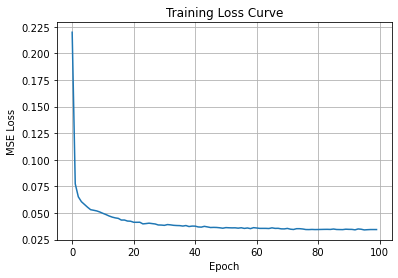

In [11]:
# Plot training loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

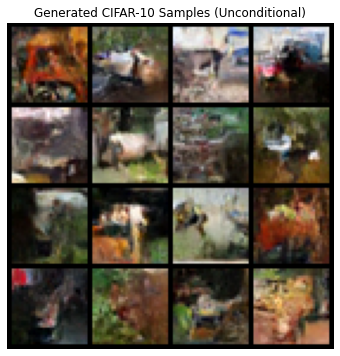

In [12]:
# Sampling + Trajectory Visualization
@torch.no_grad()
def sample(model, n_samples=16, trajectory=False):
    model.eval()

    # Start from pure Gaussian noise. 
    x = torch.randn(n_samples, 3, 32, 32).to(device)
    
    # Save the initial noise image if we want to visualize how it evolves over time 
    traj = [x.clone().cpu()] if trajectory else None
    
    for t in reversed(range(T)):
        # Construct a normalized time input t/T for each sample 
        t_tensor = torch.full((n_samples,), t, device=device).float() / T
        beta = betas[t]
        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        
        # Use the model to predict the noise added to x at this timestep
        noise_pred = model(x, t_tensor)
        
        # This is the reverse update step 
        # x_{t-1} = (1/sqrt(alpha_t)) * (x - (1 - alpha)/(sqrt(1-cumprod(alpha)))) * epsilon
        x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * noise_pred)

        # We add Gaussian noise if we are not at the final step 
        if t > 0:
            x += torch.sqrt(beta) * torch.randn_like(x)
        if trajectory:
            traj.append(x.clone().cpu())
          
    #Rescale pixel values from [-1, 1] back to [0, 1] for visualization
    return ((x.clamp(-1, 1) + 1) / 2), traj

samples, traj = sample(model, trajectory=True)

# Visualize samples (larger)
grid = make_grid(samples, nrow=4, normalize=True, value_range=(0, 1))
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Generated CIFAR-10 Samples (Unconditional)")
plt.show()

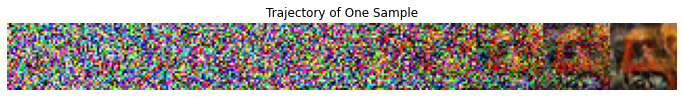

In [13]:
# Visualize trajectory of one sample (larger)
def plot_trajectory(traj, idx=0, steps=10):
    picks = np.linspace(0, len(traj)-1, steps, dtype=int)
    images = torch.cat([traj[i][idx] for i in picks], dim=2).permute(1, 2, 0)
    plt.figure(figsize=(12, 2))
    plt.imshow(((images + 1) / 2).clamp(0, 1).cpu().numpy())
    plt.axis('off')
    plt.title("Trajectory of One Sample")
    plt.show()

plot_trajectory(traj)